In [2]:
import scipy.io as sio
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from numba import jit

from sklearn.decomposition import NMF

In [ ]:
# #145 145 220
# def main():
#     # See https://rslab.ut.ac.ir/data for information about this dataset (Urban)
#     hs_image = sio.loadmat("data/Urban_R162.mat")
#     # print(type(hs_image))

#     # for key in hs_image:
#     #     print(key)

#     # Channels that are kept 
#     # print(hs_image["SlectBands"])

#     # Size of image 
#     # print(hs_image["nRow"])
#     # print(hs_image["nCol"])

#     # Number of wavelengths 
#     # print(hs_image["nBand"])

#     # Matrix itself 
#     # print(hs_image["Y"])

#     # Not sure what this mean 
#     # print(hs_image["maxValue"])

    
#     matrix = np.array(hs_image["Y"])

#     # Each row correspond to a channel/wavelength and the image is vectorized as a row vector (I am not sure how it is being flatten) 
#     # I am not sure what the value in the matrix mean. They range from 0 to 1000. I am guessing it is how much is captured by a particular channel after normalization  
#     print(matrix)

# main()

In [40]:
hs_image = sio.loadmat("data/Urban_R162.mat")
for key in hs_image:
    print(key)

print(hs_image["SlectBands"])

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue
[[  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [154]
 [155]
 [156]
 [157]
 [158]
 [159]
 [160]
 [161]
 [162]
 [163]
 [164]
 [165]
 [166]
 [167]
 [1

In [ ]:
# for i in range(0,6):
#     fst_row = H[i]
#     fst_image = H[i].reshape((307, 307))

#     plt.imshow(fst_image, interpolation='nearest')
#     plt.show()

In [3]:
@jit(nopython=True, parallel=True)
def nmf_hs(X, delta, iters, components):
    (rows, cols) = X.shape
    A = np.random.rand(rows, components)
    S = np.random.rand(components, cols)
    all_delta_X = delta * np.ones((1, cols))
    all_delta_A = delta * np.ones((1, components))
    X_bar = np.vstack((X, all_delta_X))
    for _ in range(0, iters):
        A = A * (X @ np.transpose(S)) / (A @ S @ np.transpose(S))
        A_bar = np.vstack((A, all_delta_A))
        S = S * (np.transpose(A_bar) @ X_bar) / (np.transpose(A_bar) @ A_bar @ S)
        print(np.linalg.norm(X - A @ S))
    error = (np.linalg.norm(X - A @ S))
    return A, S, error 

In [4]:
hs_image = sio.loadmat("data/Urban_R162.mat")
X = np.array(hs_image["Y"]).astype(np.float64)

W, H, error = nmf_hs(X, 1000.0, 1000, 6)
error 

443411.68034987006
282603.0640009299
260130.54402151483
250881.29263290568
245483.31987283158
241508.07457569832
237987.4420223474
234364.3831514696
230198.1025991842
225070.53319083134
218583.38013868875
210428.12983356876
200517.51211408302
189123.94894471727
176917.29830050163
164814.9106796456
153690.80371278513
144117.61370590903
136282.32968211468
130068.81180149564
125203.8958692806
121378.46892716482
118314.30467274196
115787.16546837619
113626.20442701135
111704.51250938968
109928.49231834072
108228.99163494747
106554.80879838814
104868.29473933627
103142.5440621916
101359.6756906128
99509.77710877804
97590.16848255224
95604.72465359503
93563.07728012334
91479.60706709608
89372.22176745342
87260.9892532465
85166.74439551818
83109.80410450214
81108.90492369232
79180.43115348046
77337.94495754885
75591.98082382027
73950.04010346971
72416.72189014929
70993.94198045011
69681.2075744424
68475.9299949674
67373.76647818401
66368.97586275928
65454.76149769114
64623.57510333924
63867.3

28387.955576285814

In [5]:
np.ones((1, 6)) @ H

array([[0.99835235, 0.99895997, 0.9978159 , ..., 0.99743792, 0.99738393,
        0.9973237 ]])

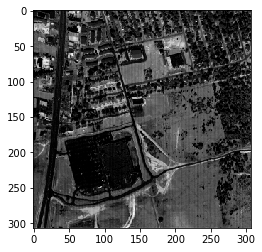

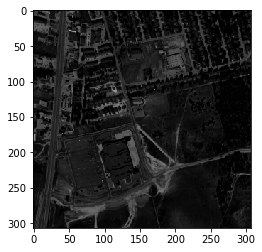

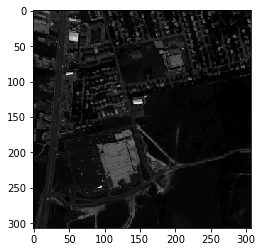

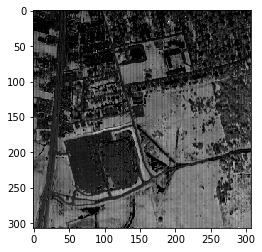

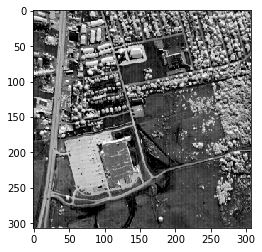

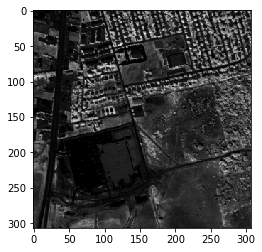

In [6]:
for i in range(0,6):
    fst_row = H[i]
    fst_image = H[i].reshape((307, 307))

    plt.imshow(fst_image, cmap='gray', interpolation='nearest')
    plt.show()

In [61]:
wavelength = hs_image["SlectBands"]

def radiation_expected(wavelength):
    return 3.8 * 10**8 / wavelength

def convertWToReflectivity(W):
    if(len(wavelength) != len(W)): return None
    newW = []

    for i in range(len(W)):
        newRow = []
        for j in range(len(W[i])):
            val =( W[i][j] / radiation_expected(wavelength[i])) * 100
            newRow += [val]
        newW += [newRow]

    newW = np.array(newW)[:,:,0]
    return newW

def plot_endmembers(W, n_comps, title="Endmembers"):
    W_t = W.transpose()
    bands = range(162)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.xlabel("Bands")
    plt.ylabel("Reflectance")
    plt.title(title)
    for i in range(n_comps):
        plt.plot(bands, W_t[i], color = colors[i])
    plt.show()

(162, 6)
(162, 6)


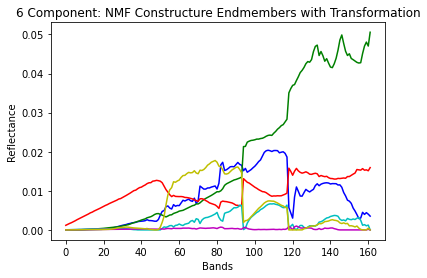

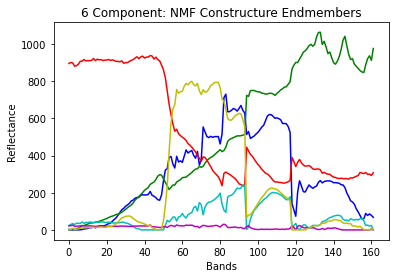

In [63]:
print(W.shape)

W_reflection = convertWToReflectivity(W)
# print(W_reflection)
print(W_reflection.shape)

plot_endmembers(W_reflection, 6, title="6 Component: NMF Constructure Endmembers with Transformation")
plot_endmembers(W, 6, title="6 Component: NMF Constructure Endmembers")



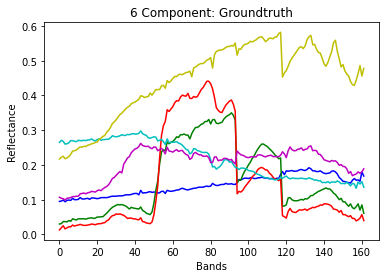

In [38]:
hs_image = sio.loadmat("data/groundTruth_Urban_end6/end6_groundTruth.mat")

W_gt6 = hs_image["M"]
plot_endmembers(W_gt6, 6, title="6 Component: Groundtruth")



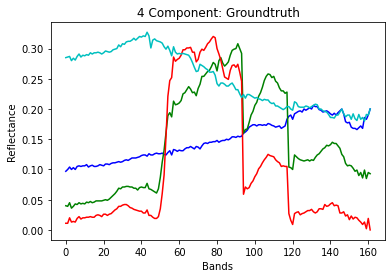

In [39]:
hs_image = sio.loadmat("data/groundTruth/end4_groundTruth.mat")

W_gt4 = hs_image["M"]
plot_endmembers(W_gt4, 4, title="4 Component: Groundtruth")
